# Shield Database Data-scraping and Visualization

In this notebook, we deconstruct the exeuctable python script "shieldScraper.py" and demonstrate how to scrape FACS data from the shield database and make a few pretty pictures.

## Import our Libraries

The first step is to import our requisite libraries...make sure they're installed.  There are some hidden dependencies as well - namely "lxml" (for beautifulsoup4) and "html5lib" (for pandas)...so be aware that those will need to be installed as well

In [1]:
# For Data Management (csv files, dataframes, directory handling)
import pandas as pd
import numpy as np
import csv
from pathlib import Path
from scipy.stats import zscore

# For interfacing with the website
import requests
from bs4 import BeautifulSoup
import urllib.request

# For making pretty pictures
import seaborn as sns
import matplotlib.pyplot as plt

# For displaying the figures inline
%matplotlib inline

## Import our list of genes

The next step is to open up our list of genes that we're interested in. The files containing these genes are just a utf8 encoded csv file - one gene per line.

In [2]:
# Put your path to the gene file here
pathToFile = "Deafness_gene_list.csv"

geneFile = open(pathToFile, 'r', encoding='utf-8-sig')
reader = csv.reader(geneFile)
geneList = [row[0] for row in reader]

# Print the list to the notebook
print(geneList)

['BSND', 'CDC14A', 'COL11A1', 'COL9A2', 'ESPN', 'GJB3', 'GPSM2', 'KCNJ10', 'KCNQ4', 'ROR1', 'TNFRSF25', 'USH2A', 'CDH23', 'PCDH15', 'COL2A1', 'DIABLO', 'DIAPH3', 'EDNRB', 'EPS8', 'GJB2', 'GJB6', 'KITLG', 'MSRB3', 'OTOGL', 'P2RX2', 'POLR1D', 'PTPRQ', 'SLC17A8', 'CLDN14', 'COL4A3', 'COL4A4', 'EDN3', 'KCNE1', 'MYO15A', 'OSBPL2', 'PAX3', 'TMPRSS3', 'TSPEAR', 'ACTG1', 'ALMS1', 'ATP6V1B1', 'CEACAM16', 'CLPP', 'DFNB59', 'ELMOD3', 'GIPC3', 'LOXHD1', 'LOXL3', 'MYH14', 'OTOF', 'PNPT1', 'S1PR2', 'SIX5', 'SYNE4', 'TMEM132E', 'USH1G', 'AIFM1', 'COL4A5', 'COL4A6', 'GRHL2', 'POU3F4', 'PRPS1', 'SMPX', 'TIMM8A', 'TJP2', 'TMC1', 'TNC', 'TPRN', 'WHRN', 'ADCY1', 'CD164', 'COL9A1', 'DFNA5', 'EYA1', 'EYA4', 'FGFR1', 'HGF', 'MET', 'MIR182', 'MIR183', 'MIR96', 'MYO6', 'PEX1', 'PSMC2', 'SLC26A4', 'SLC26A5', 'SNAI2', 'ATP2B2', 'CACNA1D', 'LARS2', 'MITF', 'MYH9', 'SOX10', 'TBX1', 'TMIE', 'TRIOBP', 'ADGRV1', 'BDP1', 'CCDC50', 'CISD2', 'CLRN1', 'DSPP', 'GRXCR1', 'HSD17B4', 'ILDR1', 'MARVELD2', 'MCM2', 'OPA1', 'SLC

## Data Organization

For the sake of keeping organized, we're going to make some directories and sub-directories to contain our data.  Specifically, we're going to make a folder to hold our heatmaps and our csv files.  We're also going to make a subdirectory within the csv files directory to hold csv files for individual genes.

Directory structure:

`
.
├── charts
├── heatmaps
├── csvFiles
│   ├── cochleaGFPPos.csv
│   ├── cochleaGFPNeg.csv
│   ├── utricleGFPPos.csv
│   ├── utricleGPFNeg.csv
│   └── individualGenes
│       ├── gene1.csv 
│       └── gene2.csv
`

In [3]:
Path("charts").mkdir(parents=True, exist_ok=True)
Path("heatmaps").mkdir(parents=True, exist_ok=True)
Path("csvFiles/individualGenes/").mkdir(parents=True, exist_ok=True)

## Scrape the charts from the website

First, we're going to scrape the FACS sorted RNA-seq graphs corresponding to each gene within the list that we imported above, and we're going to store them in the 'charts' subdirectory that we just made

Note that there won't be FACS data for every gene - so the output of the cell below will just be a list of genes for which the scraper failed to download an image

In [4]:
# Define the 'base' URL which we're going to use to request pages corresponding
# to each of the genes we're interested in
baseUrl = "https://shield.hms.harvard.edu/viewgene.html?gene="

for gene in geneList:
    gene = gene.capitalize()
    page = requests.get(baseUrl+gene)
    soup = BeautifulSoup(page.content, 'html.parser')
    chart = soup.find(id = "FACS_chart")
    # Un-comment the following line if you want to get realtime progress
    #print("Downloading chart for gene: "+gene)
    #print(chart['href'])
    try:
        urllib.request.urlretrieve(chart['href'], "charts/"+gene+".png")
    except:
        print("Error: No RNASeq data found for "+gene)

Error: No RNASeq data found for Otogl
Error: No RNASeq data found for Tspear
Error: No RNASeq data found for Loxhd1
Error: No RNASeq data found for Timm8a
Error: No RNASeq data found for Mir182
Error: No RNASeq data found for Mir183
Error: No RNASeq data found for Mir96
Error: No RNASeq data found for Adgrv1
Error: No RNASeq data found for Dcdc2
Error: No RNASeq data found for Serpinb6
Error: No RNASeq data found for Lrtomt
Error: No RNASeq data found for Pdzd7
Error: No RNASeq data found for Twnk


## Scrape the raw data from the website

So, now that we've demonstrated that we can scrape charts - let's also scrape the raw data.  This will allow us to directly visualize and manipulate the data here in the notebook.

We're also going to export these scraped tables as csv files into the "csvFiles/individualGenes/" directory


In [5]:
# Initialize an empty list to store all of our tables
dfList = []

for gene in geneList:
    gene = gene.capitalize()
    # Uncomment the following line to get real-time progress updates
    #print("Downloading table for gene: "+gene)
    page = requests.get(baseUrl+gene)
    soup = BeautifulSoup(str(page.content), 'lxml')
    try:
        table = soup.find(id = "FACS_data_table")
    except:
        table = None
    if table:
        df = pd.read_html(str(table))[0].rename(columns = {"Unnamed: 0":gene})
        df.to_csv("csvFiles/individualGenes/"+gene+".csv")
        dfList.append(df)
    else:
        print("Error: No RNASeq data found for "+gene)

Error: No RNASeq data found for Otogl
Error: No RNASeq data found for Tspear
Error: No RNASeq data found for Loxhd1
Error: No RNASeq data found for Timm8a
Error: No RNASeq data found for Mir182
Error: No RNASeq data found for Mir183
Error: No RNASeq data found for Mir96
Error: No RNASeq data found for Adgrv1
Error: No RNASeq data found for Dcdc2
Error: No RNASeq data found for Serpinb6
Error: No RNASeq data found for Lrtomt
Error: No RNASeq data found for Pdzd7
Error: No RNASeq data found for Twnk


## Massage/combine our data

Alright, so now we have a list of tables (stored as dataframes).  Each data frame takes the following format (example for the gene 'Bsnd'):

|    | Bsnd               |   E16a |   E16b |   P0 |   P4 |   P7 |   P16 |
|---:|:-------------------|-------:|-------:|-----:|-----:|-----:|------:|
|  0 | Utricle GFP+ cells |      0 |      3 |    5 |    2 |    3 |    19 |
|  1 | Cochlea GFP+ cells |      0 |      3 |    0 |    0 |    0 |   nan |
|  2 | Utricle GFP- cells |     12 |      6 |    1 |    0 |    0 |    15 |
|  3 | Cochlea GFP- cells |      0 |      9 |    2 |    0 |    0 |   nan |

So, as you can see from the above table, for each gene we have rows (corresponding to conditions) and columns (corresponding to timepoints).  What we'd like to do is make separate dataframes for each condition, each containing all of the timepoints as well as the name of the corresponding gene.  We can do so with the following cell:

In [6]:
# Get a list of conditions
listOfConditions = dfList[0][dfList[0].columns[0]].unique()
# Printe em Out
print(listOfConditions)
# Define a function to avoid the need to copy and paste code four times

def combineTablesByCondition(listOfDataframes, condition):
    """Given a list of dataframes and a condition, combine those
       dataframes into a single, aggregated dataframe"""
    
    # Initialize a new, empty dataframe
    aggregateDf = pd.DataFrame()

    for tmpDf in listOfDataframes:
        aggregateDf[tmpDf.columns[0]] = tmpDf[tmpDf[tmpDf.columns[0]] == condition].iloc[0]
    
    return aggregateDf.T.drop(aggregateDf.T.columns[0], axis = 1).fillna(0)
    
# Invoke function for each condition
UtricleGFPPosDf = combineTablesByCondition(dfList, listOfConditions[0])
CochleaGFPPosDf = combineTablesByCondition(dfList, listOfConditions[1])
UtricleGFPNegDf = combineTablesByCondition(dfList, listOfConditions[2])
CochleaGFPNegDf = combineTablesByCondition(dfList, listOfConditions[3])

['Utricle GFP+ cells' 'Cochlea GFP+ cells' 'Utricle GFP- cells'
 'Cochlea GFP- cells']


Now our dataframes are separted by condition and look like the following:

In [7]:
UtricleGFPPosDf

,E16a,E16b,P0,P4,P7,P16
Bsnd,0,3,5,2,3,19.0
Cdc14a,737,615,622,750,950,1464.0
Col11a1,433,817,279,283,411,84.0
Col9a2,6883,3580,2520,1214,3620,640.0
Espn,65,22,39,52,120,875.0
...,...,...,...,...,...,...
Myo7a,247,110,606,754,1183,385.0
Nars2,65,41,60,58,95,84.0
Otog,294,261,223,360,1435,464.0
Tectb,1622,3950,3241,3281,5954,1974.0


So each dataframe contains a bunch of rows (genes) and columns (timepoints) corresponding to each individual condition.  Let's save these dataframes as csv files. 


In [8]:
UtricleGFPPosDf.to_csv("csvFiles/"+listOfConditions[0]+".csv")
CochleaGFPPosDf.to_csv("csvFiles/"+listOfConditions[1]+".csv")
UtricleGFPNegDf.to_csv("csvFiles/"+listOfConditions[2]+".csv")
CochleaGFPNegDf.to_csv("csvFiles/"+listOfConditions[3]+".csv")

With that out of the way, let's start making some pretty pictures! To start, let's define a function which renders a basic heatmap of the RNASeq data

In [9]:
def heatMap(dataFrame, conditionName):
    # Set figure size
    # Going to allocate 0.25" per line to ensure readability
    plt.figure(figsize = (5, 0.25*len(dataFrame)))
    ax = sns.heatmap(dataFrame, cmap = "bwr")
    plt.savefig("heatmaps/"+conditionName+".png")

Now, we can invoke the function to render and save each of these heatmaps (saves some copy and pasting)

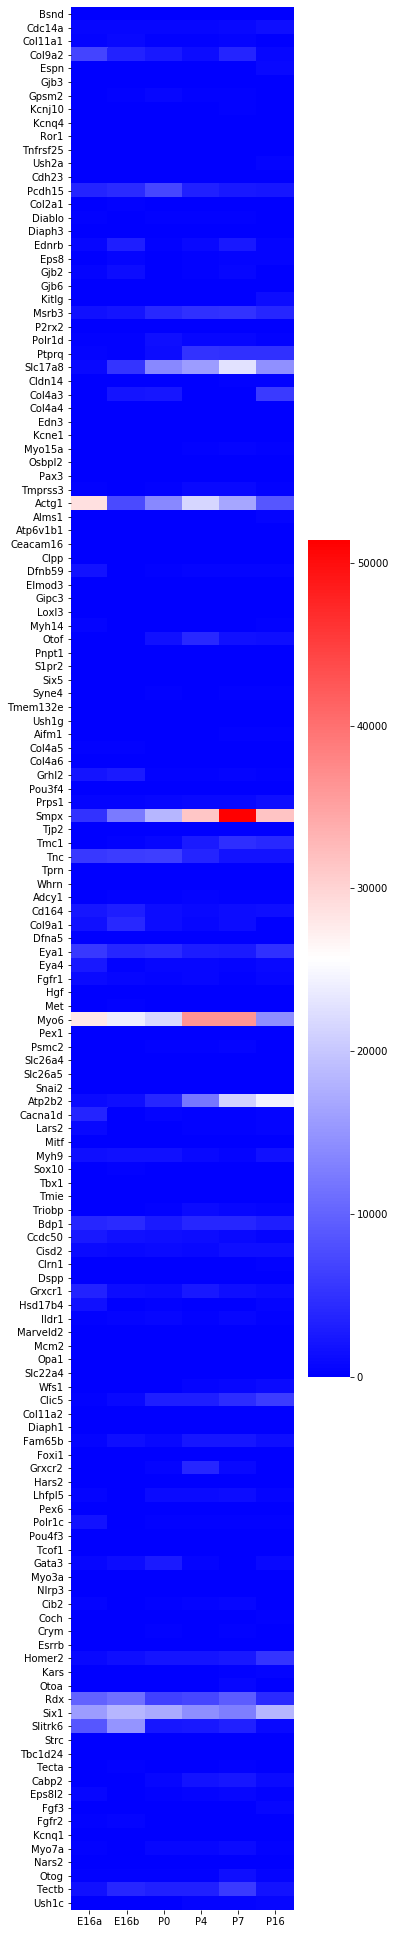

<Figure size 360x2520 with 0 Axes>

<Figure size 360x2520 with 0 Axes>

<Figure size 360x2520 with 0 Axes>

In [10]:
# For example, we'll display the first figure inline
heatMap(UtricleGFPPosDf, listOfConditions[0])

# and the rest we'll suppress the output by invoking plt.clf()
heatMap(CochleaGFPPosDf, listOfConditions[1])
plt.clf()
heatMap(UtricleGFPNegDf, listOfConditions[2])
plt.clf()
heatMap(CochleaGFPNegDf, listOfConditions[3])
plt.clf()

## Implementing gene clustering

So, this is pretty cool and all, but I think we can take it one step further.  Seaborn supports a kind of plot known as a "clustermap" which not only depcts data as a heatmap, but also clusters together data by their relative similarity to one another.  In this case, we can cluster the genes which have the most similar expression together.

For the full documentation about the built-in function, check out this link: https://seaborn.pydata.org/generated/seaborn.clustermap.html

For details about the clustering algorithms that we can choose, check out this link: 
https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

In [11]:
def clusterMap(dataFrame, conditionName, logScale = False, saveFig = True):
    if logScale == True:
        dataFrame = np.log10(dataFrame + 1e-1)
    # Set figure size
    # Going to allocate 0.25" per line to ensure readability
    g = sns.clustermap(dataFrame, method = 'ward', col_cluster = False, cmap = "bwr", z_score = None,
                       cbar_pos=(1.0, .2, .03, .4), dendrogram_ratio = (0.2,0.01), figsize = (5, 0.33*len(dataFrame)))
    #g.cax.set_visible(False)
    #g.ax_row_dendrogram.set_visible(False)
    if saveFig == True:
        if logScale == False:
            plt.savefig("heatmaps/"+conditionName+"(Clustered).png", bbox_inches='tight',pad_inches = 0)
        else:
            plt.savefig("heatmaps/"+conditionName+"(Clustered, log10).png", bbox_inches='tight',pad_inches = 0)

Now we can just invoke this function to generate a bunch of clustered heatmaps

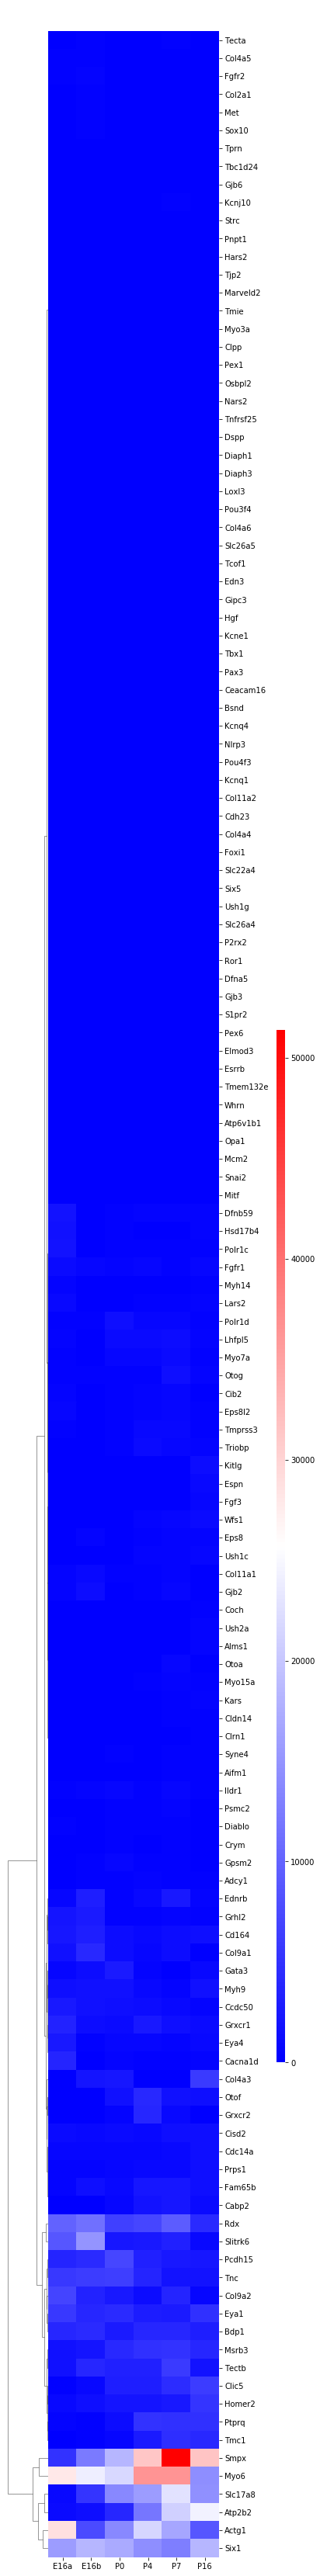

<Figure size 360x3326.4 with 0 Axes>

<Figure size 360x3326.4 with 0 Axes>

<Figure size 360x3326.4 with 0 Axes>

In [12]:
# Output the first one to the notebook
clusterMap(UtricleGFPPosDf, listOfConditions[0])

# And suppress the output of the rest (they're still saved though...)
clusterMap(CochleaGFPPosDf, listOfConditions[1])
plt.clf()
clusterMap(UtricleGFPNegDf, listOfConditions[2])
plt.clf()
clusterMap(CochleaGFPNegDf, listOfConditions[3])
plt.clf()

Well, I think we can improve a little further right?  One issue is that the scale goes from 0 (literally no reads) to ~5E4.  This means that the overwhelming number of genes are just going to be subtly different shades of dark blue.  One way to circumvent this issue (to make the graph a littl emore visually useful) is to log-transform the data.  I've coded a variable that you can pass to this function to log-transform the data prior to clustering and rendering.  Check it out in action below

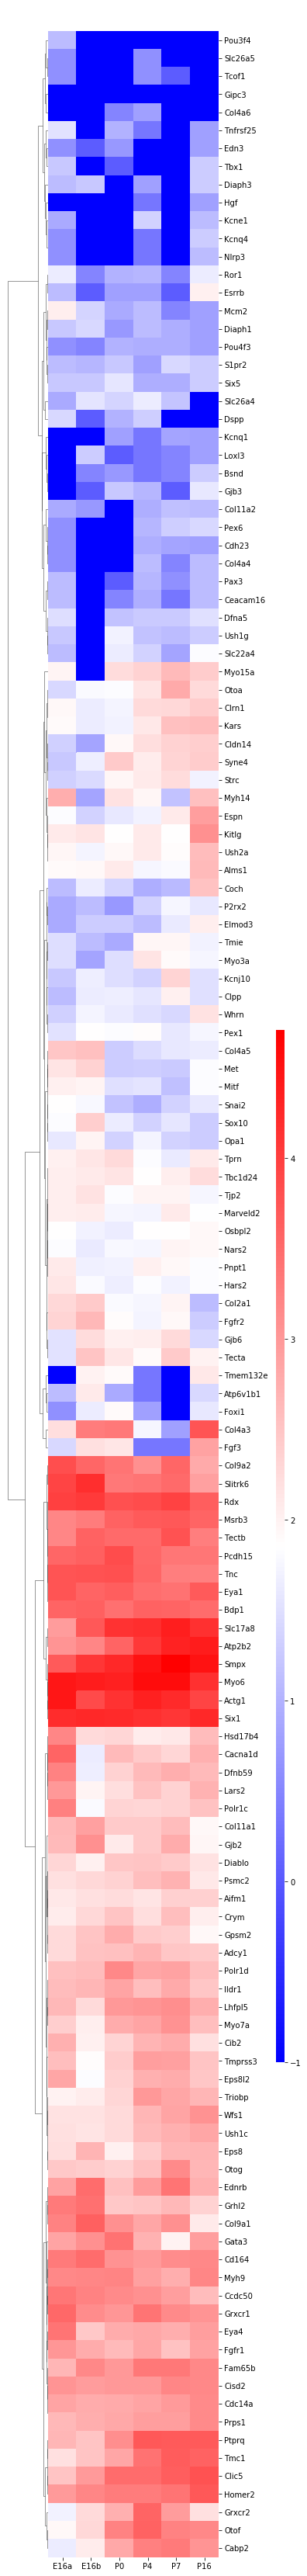

<Figure size 360x3326.4 with 0 Axes>

<Figure size 360x3326.4 with 0 Axes>

<Figure size 360x3326.4 with 0 Axes>

In [13]:
# New and improved with 100% more log10
clusterMap(UtricleGFPPosDf, listOfConditions[0], logScale=True)

# And again suppress the output of the rest
clusterMap(CochleaGFPPosDf, listOfConditions[1], logScale=True)
plt.clf()
clusterMap(UtricleGFPNegDf, listOfConditions[2], logScale=True)
plt.clf()
clusterMap(CochleaGFPNegDf, listOfConditions[3], logScale=True)
plt.clf()

Now look at that - things cluster more clearly AND we have a direct interpretation for a value of -1 (dark blue) which is that there aren't any reads for that gene in that particular sample.  Now you can start to identify potentially interesting clusters within your data!

I'm not goign to over-interpret here, but maybe you could start to look at differences in overall expression along with the dynamics of expression.  For instance, can you see a cluster of highly expressed genes which diminish with increasing time?  How about lowly expressed genes which increase in expression with time?

## Conclusions

Anyways, that's kidn of all for now.  I hope this helps...Cole.  I hope it helps Cole